# Customer Transaction Prediction

Datasets: Santander customer transaction prediction

Look to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.

The features do not have names for data protection, each row contains 200 numerical values. The following notebook will go through the process of exploring data, prepare it for modeling, training the underlying model and predict values for test set.

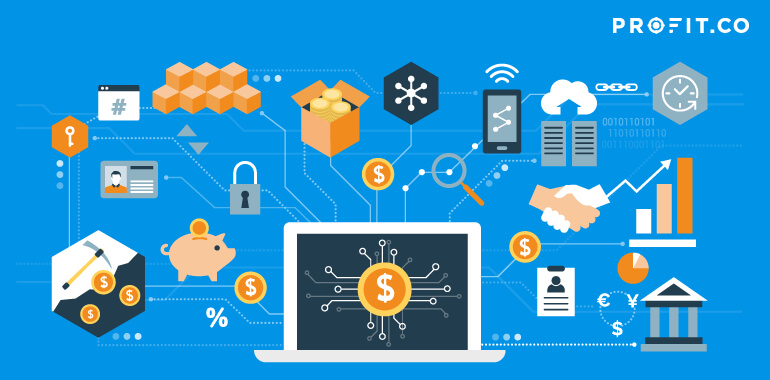


# Set up kernel environment

Setup using Kaggle provided docker images

In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-transaction-prediction-dataset/train.csv
/kaggle/input/santander-customer-transaction-prediction-dataset/test.csv


## Packages

Download the relevant packages.

In [68]:
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import os
import lightgbm as lgb
warnings.filterwarnings('ignore')

## Load dataset

Load in the dataset with pandas dataframes

In [69]:
PATH="../input/santander-customer-transaction-prediction-dataset/"

In [70]:
%%time
train_set = pd.read_csv(PATH + "train.csv")
test_set = pd.read_csv(PATH + "test.csv")

CPU times: user 17.5 s, sys: 1.23 s, total: 18.8 s
Wall time: 18.8 s


## Data Exploration 

Let's check for missing data and data types. From the dataframes below, we can see that there are no missing data present.

### Size of data

 - train_set: 200,000 rows, 202 columns
 - test_set: 200,000 rows, 201 columns
 
### Training data
 
 - Id code: string
 - Target class: integer
 - 200 features: numerical 
 
 
### Testing data
 
 - Id code: string
 - 200 features: numerical

In [71]:
print("Train set: ", train_set.shape)
print("Test set: ", test_set.shape)

Train set:  (200000, 202)
Test set:  (200000, 201)


In [72]:
train_set.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [73]:
test_set.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


## Check for missing data

We can check for missing values using the following method.

In [74]:
def check_for_missing_data(dataset):
    """Checks for missing data.

    Args:
      dataset: pandas df

    Returns:
      dataset with missing info: pandas df
    """
    missing_data_count = dataset.isnull().sum()
    percent = (missing_data_count / dataset.isnull().count() * 100)
    df_missing_data = pd.concat([missing_data_count, percent], axis = 1, keys = ['missing_data_count', "percent"])
    types = []
    for col in dataset.columns:
        dtypes = str(dataset[col].dtype)
        types.append(dtypes)
    df_missing_data["types"] = types
    return (np.transpose(df_missing_data))

In [75]:
%%time 
check_for_missing_data(train_set)

CPU times: user 193 ms, sys: 12.1 ms, total: 205 ms
Wall time: 204 ms


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
missing_data_count,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [76]:
%%time
check_for_missing_data(test_set)

CPU times: user 189 ms, sys: 10 ms, total: 199 ms
Wall time: 196 ms


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
missing_data_count,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


## Check numerical values statistics

Observations:
 - The standard deviation is large for both train and test sets
 - All other distributions look similar

In [77]:
train_set.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [78]:
test_set.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


## Scatter plots

We can check the scatter plots of a few of the features. The subset contains less than 10% of the dataset. X - axis shows train dataset, Y - axis shows test dataset.

<Figure size 640x480 with 0 Axes>

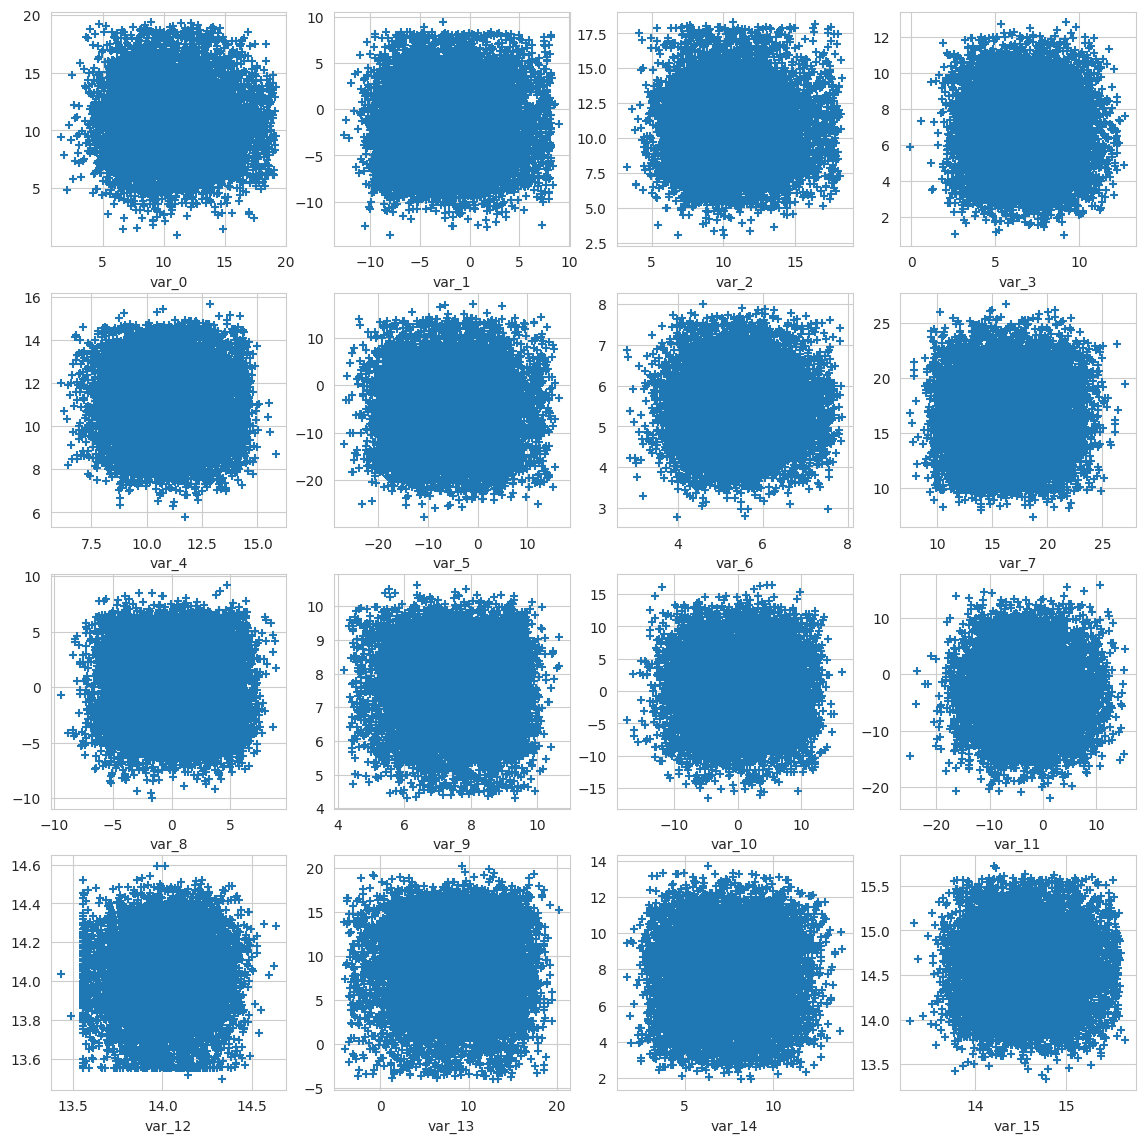

In [79]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
            ]
i = 0
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4, 4, figsize = (14, 14))
for feature in features:
    i += 1
    plt.subplot(4, 4, i)
    plt.scatter(train_set[::20][feature], test_set[::20][feature], marker = "+")
    plt.xlabel(feature, fontsize = 10)
plt.show()

## <a id='32'> Distribution of the target class</a>  
Imabalance of the target variable can be seen below.

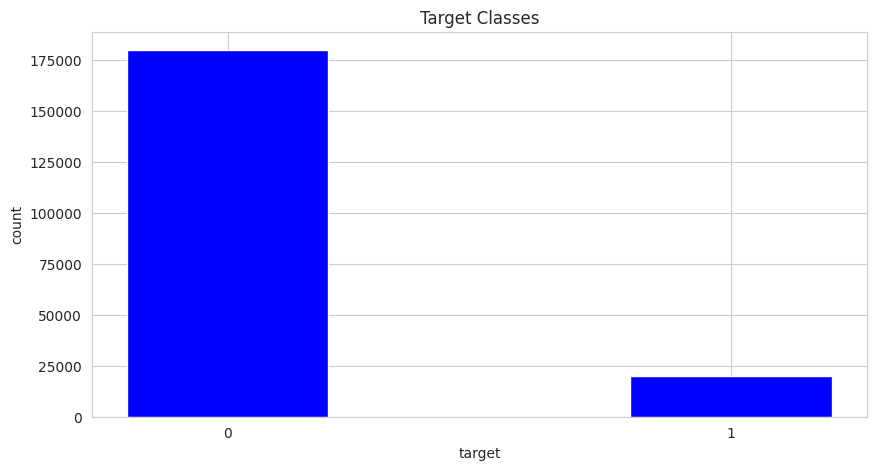

In [80]:
target_zero = sum(train_set['target'] == 0)
target_one = sum(train_set['target'] == 1)
# creating the dataset
data = {'0':target_zero, '1':target_one}
targets = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(targets, values, color ='blue',
        width = 0.4)

plt.xlabel("target")
plt.ylabel("count")
plt.title("Target Classes")
plt.show()

## <a id='32'> Distribution of mean and std</a>  

We can check the distribution of the mean values per row in the train and test sets.

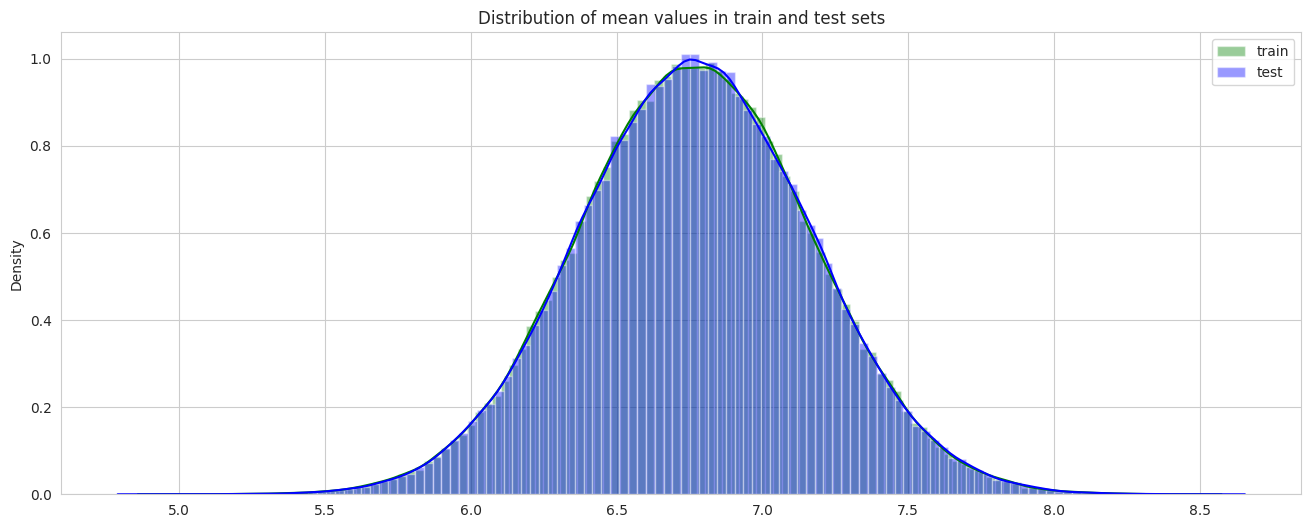

In [81]:
plt.figure(figsize = (16, 6))
features = train_set.columns.values[2:202]
plt.title("Distribution of mean values in train and test sets")
sns.distplot(train_set[features].mean(axis = 1), color = "green", kde = True, bins = 120, label = "train")
sns.distplot(test_set[features].mean(axis = 1), color = "blue", kde = True, bins = 120, label = "test")
plt.legend()
plt.show()

## <a id='32'> Distribution of standard deviation per row for train and test sets</a>  

We can check the distribution of the mean values per row in the train and test sets.

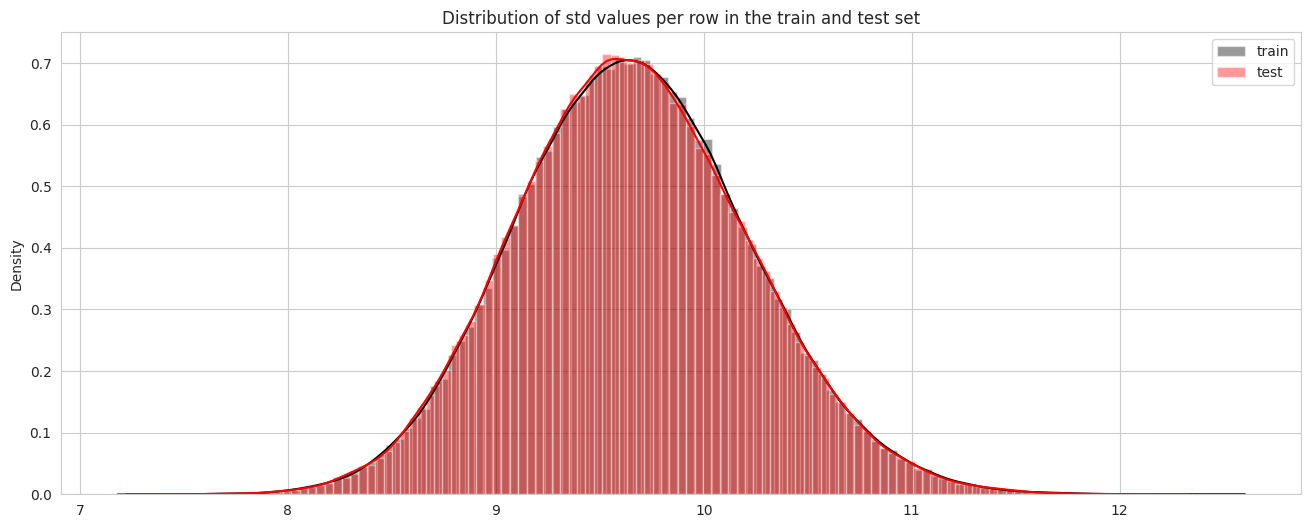

In [82]:
plt.figure(figsize = (16, 6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train_set[features].std(axis = 1), color = "black", kde = True, bins = 120, label = "train")
sns.distplot(test_set[features].std(axis = 1), color = "red", kde = True, bins = 120, label = "test")
plt.legend()
plt.show()

## <a id='32'> Skew and kurtosis</a>  

We can check the distribution of the skew values per row and columns. Can also the the skew in train and test sets.

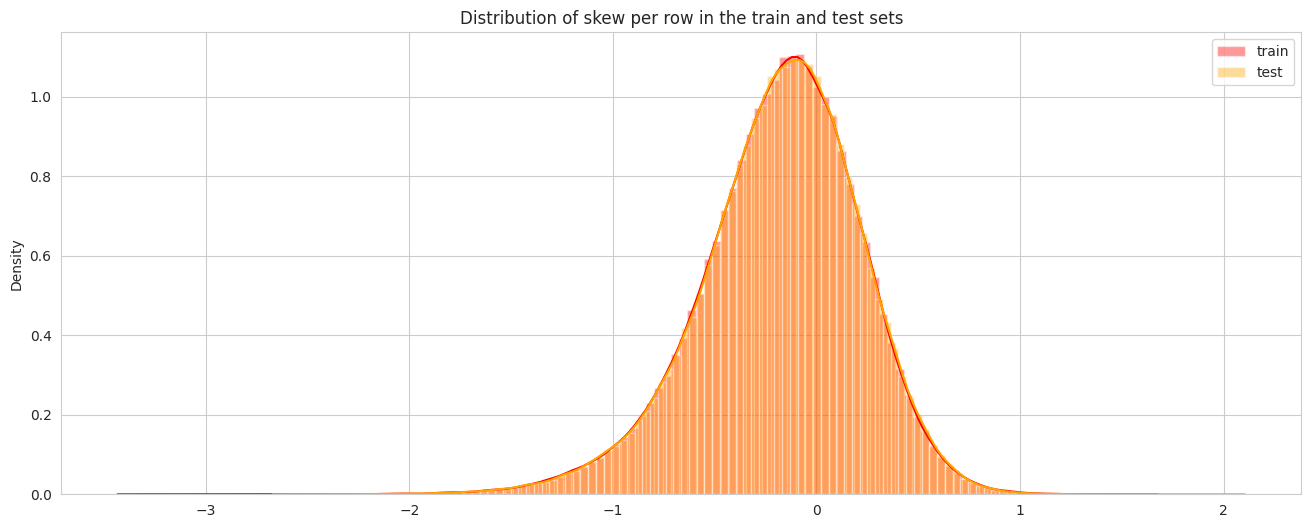

In [83]:
plt.figure(figsize = (16, 6))
plt.title("Distribution of skew per row in the train and test sets")
sns.distplot(train_set[features].skew(axis = 1), color = "red", kde = True, bins = 120, label = "train")
sns.distplot(test_set[features].skew(axis = 1), color = "orange", kde = True, bins = 120, label = "test")
plt.legend()
plt.show()

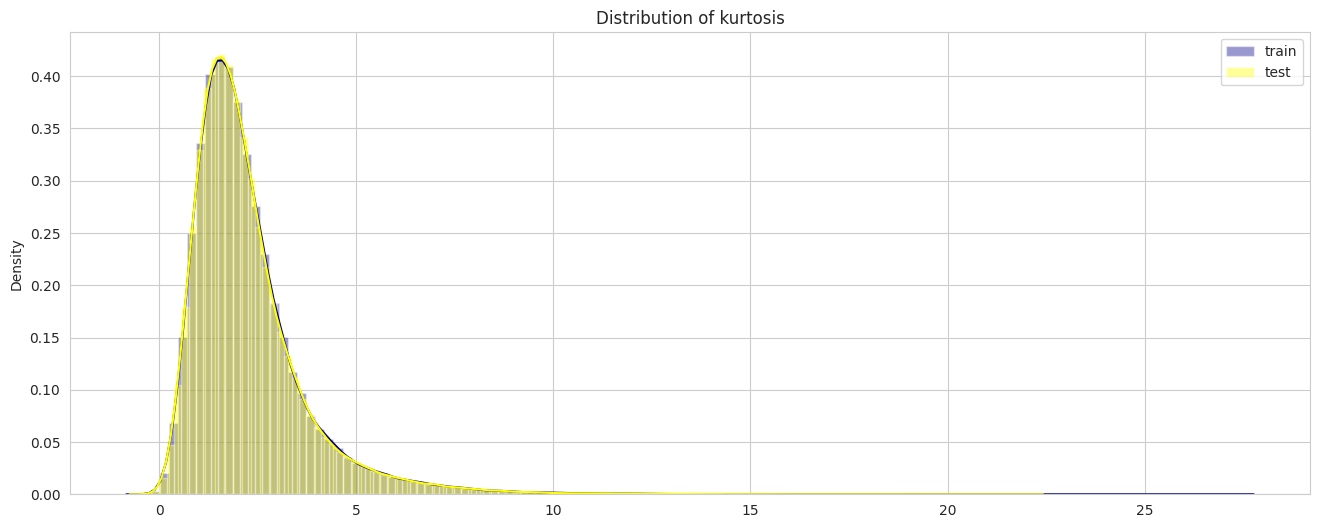

In [84]:
plt.figure(figsize = (16, 6))
plt.title("Distribution of kurtosis")
sns.distplot(train_set[features].kurtosis(axis = 1), color = "darkblue", kde = True, bins = 120, label = "train")
sns.distplot(test_set[features].kurtosis(axis = 1), color = "yellow", kde = True, bins = 120, label = "test")
plt.legend()
plt.show()

## Correlations


In [85]:
%%time 
corr_train = train_set[features].corr()
corr_train.head()

CPU times: user 21.6 s, sys: 59.2 ms, total: 21.7 s
Wall time: 21.7 s


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
var_0,1.000000,-0.000544,0.006573,0.003801,0.001326,0.003046,0.006983,0.002429,0.004962,-0.002613,...,0.002752,0.000206,-0.005373,0.001616,-0.001514,0.002073,0.004386,-0.000753,-0.005776,0.003850
var_1,-0.000544,1.000000,0.003980,0.000010,0.000303,-0.000902,0.003258,0.001511,0.004098,-0.000832,...,0.006627,0.003621,-0.002604,0.001153,-0.002557,-0.000785,-0.000377,-0.004157,-0.004861,0.002287
var_2,0.006573,0.003980,1.000000,0.001001,0.000723,0.001569,0.000883,-0.000991,0.002648,-0.001932,...,0.000197,0.001285,-0.003400,0.000549,0.002104,-0.001070,0.003952,0.001078,-0.000877,0.003855
var_3,0.003801,0.000010,0.001001,1.000000,-0.000322,0.003253,-0.000774,0.002500,0.003553,-0.000826,...,0.000151,0.002445,-0.001530,-0.001699,-0.001054,0.001206,-0.002800,0.001164,-0.001651,0.000506
var_4,0.001326,0.000303,0.000723,-0.000322,1.000000,-0.001368,0.000049,0.004549,0.001194,-0.000918,...,0.001514,0.004357,0.003347,0.000813,-0.000068,0.003706,0.000513,-0.000046,-0.001821,-0.000786


In [86]:
features = train_set.columns.values[2:202]

## <a id='32'> Model </a>  

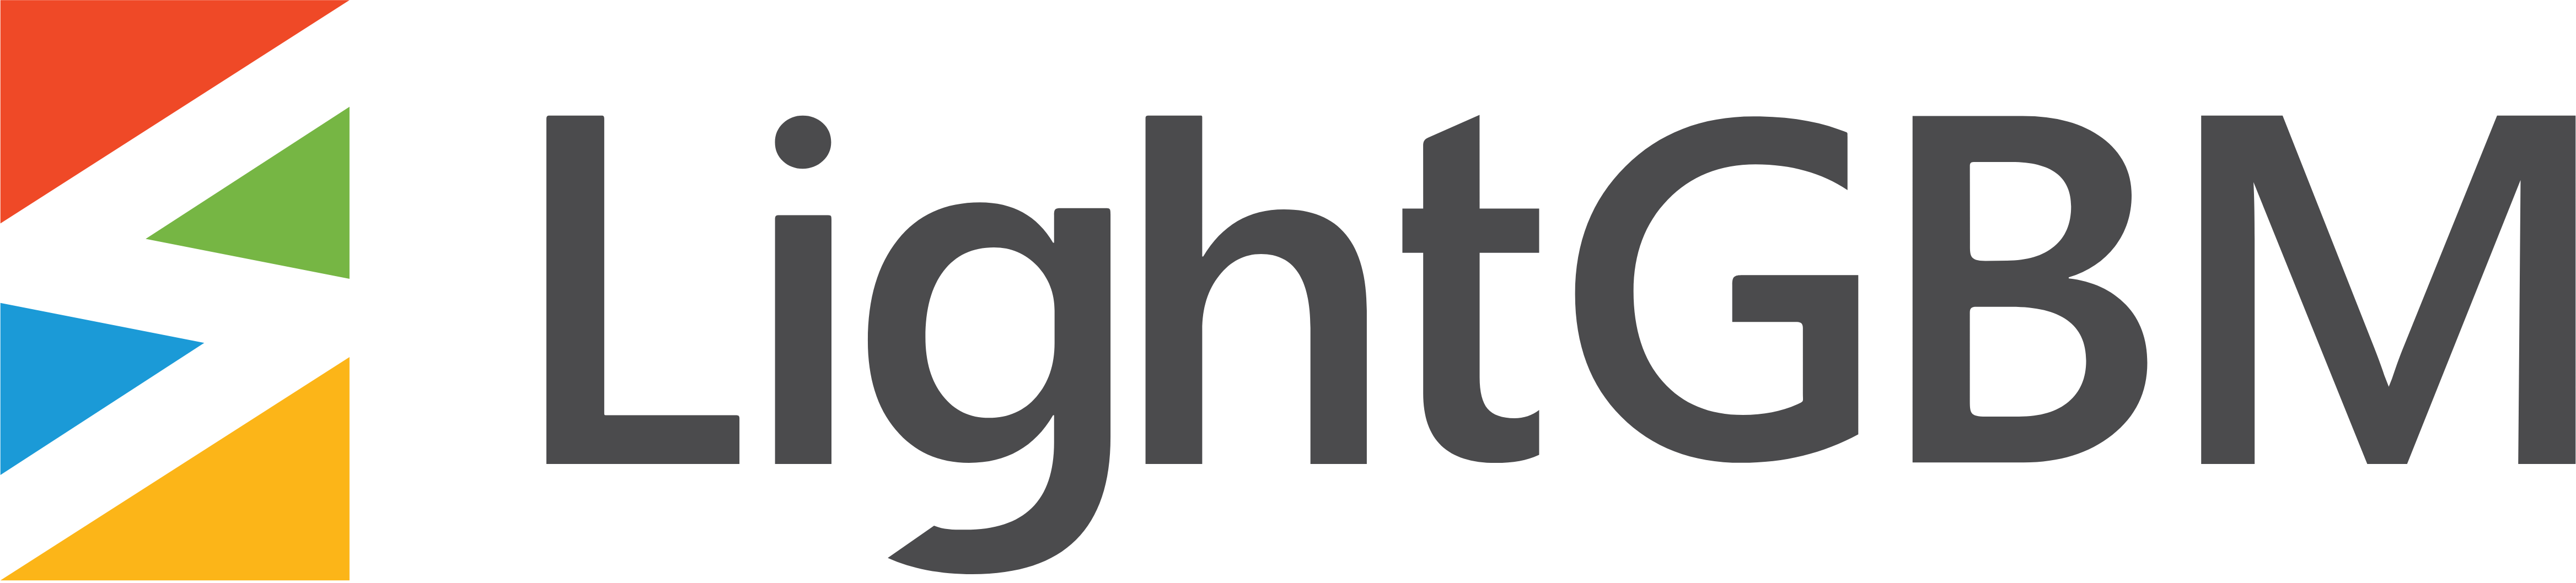!
## LightGBM

A gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel, distributed, and GPU learning.
- Capable of handling large-scale data.


In [87]:
features = [col for col in train_set.columns if col not in ["ID_code", "target"]]
target = train_set["target"]

In [88]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [89]:
folds = StratifiedKFold(n_splits=10, shuffle=False)
folds_scores = np.zeros(len(train_set))
predictions = np.zeros(len(test_set))
df_importance_features = pd.DataFrame()

In [90]:
for _fold, (train_idx, val_idx) in enumerate(folds.split(train_set.values, target.values)):
    print("Fold: ", _fold)
    train_data = lgb.Dataset(train_set.iloc[train_idx][features], label = target.iloc[train_idx])
    val_data = lgb.Dataset(train_set.iloc[val_idx][features], label = target.iloc[val_idx])
    rounds = 100
    classifier = lgb.train(param, train_data, rounds, valid_sets = [train_data, val_data])
    folds_scores[val_idx] = classifier.predict(train_set.iloc[val_idx][features], num_iteration = classifier.best_iteration)
    df_importance_fold = pd.DataFrame()
    df_importance_fold["Feature"] = features
    df_importance_fold["importance"] = classifier.feature_importance()
    df_importance_fold["fold"] = _fold + 1
    df_importance_features = pd.concat([df_importance_features, df_importance_fold], axis = 0)
    
    predictions += classifier.predict(test_set[features], num_iteration = classifier.best_iteration) / folds.n_splits
print("CV score: ", roc_auc_score(target, folds_scores))

Fold:  0
[LightGBM] [Info] Number of positive: 18089, number of negative: 161911
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
Fold:  1
[LightGBM] [Info] Number of positive: 18089, number of negative: 161911
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
Fold:  2
[LightGBM] [Info] Number of positive: 18088, number of negative: 161912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.248969 seconds.
You c

## <a id='32'> Model Metrics</a>  
Cross Valdiation Score: 0.83